In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
import pandas as pd
import geopandas as gpd
import random
import rasterio
from PIL import Image
import richdem as rd
from osgeo import gdal
from osgeo import ogr

In [2]:
def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # 가중치 설정. 거리에 반비례하며, 거리 계수 p=2일 경우 dist**2로 설정 가능함.
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

In [3]:
# x0와 x1사이 거리를 반환.
def distance_matrix(x0, y0, x1, y1):
    # x, y를 별개의 1차원 배열이 아니라 [[x1, y1], [x2, y2]...] 처럼 
    # (x, y) 짝을 이루는 2차원 배열로 만드는 과정 
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    # 거리 행렬 계산. 근데 굳이? 뒤집어서 또 슬라이싱? 굳이?
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

In [4]:
def scipy_idw(x, y, z, xi, yi):
    interp = Rbf(x, y, z, function='linear')
    return interp(xi, yi)

def plot(x,y,z,grid):
    plt.figure()
    # 래스터 출력. cmap으로 색상 변경 가능
    plt.imshow(grid, extent=(xmin, xmax, ymin, ymax))
    #plt.hold(True)
    # 래스터 위에 점 찍기 (굳이?)
    #plt.scatter(x,y,c=z)
    plt.colorbar()

출처 : https://stackoverflow.com/questions/3104781/inverse-distance-weighted-idw-interpolation-with-python

### 래스터 함수 인자 정의
- x, y, z
 : 래스터를 생성할 기준 point.
   모두 1차원 배열로, (x, y)는 좌표를, z는 해당 좌표의 값(가중치라던가) 를 의미한다.
   동일한 인덱스의 요소는 동일한 점의 요소

- xi, yi
 : 각각 x좌표와 y좌표의 최대와 최소값 사이를 일정 간격으로 나누는 요소들의 nx, ny크기의 배열.
 
정확한 rbf 함수 정의에 대해서는
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html 참고

## 데이터 불러오기

In [5]:
crossWalk = gpd.read_file('../data/shp/crossWalk4326.shp', encoding='euc-kr')
trafficLight = gpd.read_file('../data/shp/trafficLight4326.shp', encoding='euc-kr')
busStop = gpd.read_file('../data/shp/busStop4326.shp', encoding='euc-kr')

In [6]:
#crossWalk의 nan으로 인한 연산 무효를 방지하기 위해 dropna
idxMask = crossWalk[crossWalk['노드링크 '] == 'LINK'].index
crossWalk.drop(idxMask, inplace = True)

In [7]:
print("crossWalk =",crossWalk.shape, "trafficLight=", trafficLight.shape, "busStop =", busStop.shape)

crossWalk = (19518, 14) trafficLight= (3000, 13) busStop = (11315, 6)


In [8]:
df_crossWalk = pd.DataFrame(crossWalk)
df_trafficLight = pd.DataFrame(trafficLight)
df_busStop = pd.DataFrame(busStop)

### 데이터에 가중치 부여

In [9]:
df_crossWalk['weight'] = 4
df_trafficLight['weight'] = 1.5
df_busStop['weight'] = 3

In [10]:
print("crossWalk =",df_crossWalk.shape, "trafficLight=", df_trafficLight.shape, "busStop =", df_busStop.shape)

crossWalk = (19518, 15) trafficLight= (3000, 13) busStop = (11315, 6)


In [11]:
# geometry와 가중치만 뽑은 뒤 전체 포인트 데이터 결합
df_crossWalk = df_crossWalk[['geometry', 'weight']]
df_trafficLight = df_trafficLight[['geometry', 'weight']]
df_busStop = df_busStop[['geometry', 'weight']]

print(type(df_crossWalk))

points = pd.concat([df_crossWalk, df_trafficLight])
print(points.shape)
points = pd.concat([points, df_busStop])
print(points.shape)
points.head()

<class 'pandas.core.frame.DataFrame'>
(22518, 2)
(33833, 2)


,geometry,weight
0,POINT (127.00848 37.57274),4.0
1,POINT (126.97329 37.57417),4.0
2,POINT (127.00839 37.57269),4.0
4,POINT (127.00839 37.57306),4.0
6,POINT (127.00857 37.57253),4.0


In [12]:
# 병합한 points를 다시 geomdataframe으로 변경
points = gpd.GeoDataFrame(points)

### 래스터 함수 선언

In [13]:
xmin, xmax = 126.75, 127.2
ymin, ymax = 37.4, 37.7

In [14]:
print(ymin)

37.4


In [15]:
def raster(x, y, z, calType):
    # Setup: Generate data...\
    nx, ny = 280, 210
    
    # linearly spaced(배열 시작, 배열 끝, 요소개수)
    #  : 시작과 끝값 사이에 요소 개수만큼 사잇값들을 자동생성
    xi = np.linspace(xmin, xmax, nx)
    yi = np.linspace(ymin, ymax, ny)
    # meshgrid : 직사각형의 그리드 만들기
    xi, yi = np.meshgrid(xi, yi)
    xi, yi = xi.flatten(), yi.flatten()
    
    if calType == "idw":
        grid = simple_idw(x,y,z,xi,yi)
        grid = grid.reshape((ny, nx))
        
    else :
        print("제대로 된 calculate Type을 입력하세요. \nex ) idw, linear")
    
    return grid


### 버스정류장, 신호등, 횡단보도를 합친 points에 대해 래스터 생성

Text(0.5, 1.0, 'points')

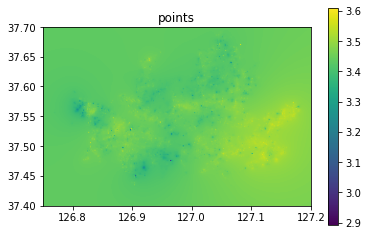

In [16]:
points_raster = raster(points.geometry.x, points.geometry.y, points.weight, "idw")
plot(points.geometry.x, points.geometry.y, points.weight, points_raster[::-1])
plt.title('points')

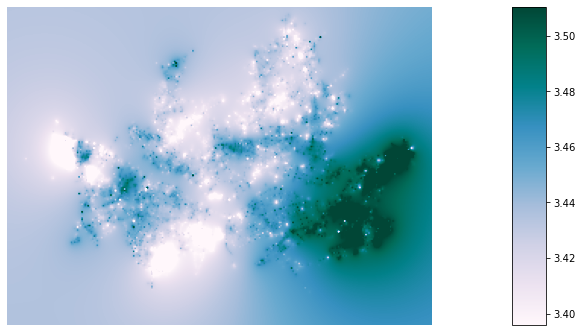

In [17]:
points_rd = rd.rdarray(points_raster[::-1], no_data=-9999)
rd.rdShow(points_rd, axes=False, cmap='PuBuGn', figsize=(10, 5));

### 결과 데이터를 래스터로 저장

In [18]:
from rasterio.crs import CRS
from rasterio.transform import from_origin

In [19]:
points_raster_reverse = points_raster[::-1]

In [20]:
points_array = np.reshape(points_raster_reverse, (1, 210, 280))
points_array

array([[[3.43282801, 3.43281016, 3.43279297, ..., 3.45005773,
         3.45016205, 3.45026366],
        [3.43277029, 3.43275195, 3.43273427, ..., 3.45017609,
         3.45028069, 3.45038251],
        [3.43271188, 3.43269302, 3.43267484, ..., 3.45029693,
         3.45040178, 3.45050379],
        ...,
        [3.43525184, 3.4352462 , 3.43524062, ..., 3.46661752,
         3.46653083, 3.46644263],
        [3.43528364, 3.43527766, 3.43527173, ..., 3.46640964,
         3.46632646, 3.46624175],
        [3.43531541, 3.43530911, 3.43530285, ..., 3.46620385,
         3.4661241 , 3.46604277]]])

In [21]:
driver = "GTiff"
dim = points_array.shape
print(dim)
height = dim[1]
width = dim[2]
count = 1
dtype = points_array.dtype
print(dtype)
crs = CRS.from_epsg(4326)

(1, 210, 280)
float64


In [22]:
help(from_origin)

Help on function from_origin in module rasterio.transform:

from_origin(west, north, xsize, ysize)
    Return an Affine transformation given upper left and pixel sizes.
    
    Return an Affine transformation for a georeferenced raster given
    the coordinates of its upper left corner `west`, `north` and pixel
    sizes `xsize`, `ysize`.



In [23]:
xsize = (xmax-xmin)/280
ysize = (ymax-ymin)/210
# top left x coordinates, y, resolution of xpixel size, resolution of ypixel size
transform = from_origin(xmin, ymax, xsize, ysize)

In [24]:
transform

Affine(0.0016071428571428673, 0.0, 126.75,
       0.0, -0.001428571428571449, 37.7)

In [28]:
with rasterio.open("../data/raster/point_to_raster.tif", "w",
                   driver = driver,
                   height = height,
                   width = width,
                   count = count,
                   dtype = dtype,
                   crs = crs,
                   transform = transform) as dst:
    dst.write(points_array)

### 각 요소에 대해 래스터 생성

가중치가 모두 동일한 데이터에 대하여 idw를 실행하면 당연히 결과가 이상하게 나온다.
아래는 폐기

In [ ]:
#dir(busStop_raster)

im1 = Image.fromarray(crossWalk_rd, mode = 'F')
im1.save("../data/raster/crossWalk_raster.tiff", "TIFF")
im2 = Image.fromarray(trafficLight_rd, mode = 'F')
im2.save("../data/raster/trafficLight_raster.tiff", "TIFF")
im3 = Image.fromarray(busStop_rd, mode = 'F')
im3.save("../data/raster/busStop_raster.tiff", "TIFF")

def plot_raster(xmin, xmax, ymin, ymax, grid):
    plt.figure()
    # 래스터 출력. cmap으로 색상 변경 가능
    plt.imshow(grid, extent=(xmin, xmax, ymin, ymax))
    plt.colorbar()

In [ ]:
#sum_raster = crossWalk_raster + busStop_raster + trafficLight_raster

print("xmin = ", crossWalk.geometry.x.min(), trafficLight.geometry.x.min(), busStop.geometry.x.min())
print("ymin = ",crossWalk.geometry.y.min(), trafficLight.geometry.y.min(), busStop.geometry.y.min())
print("xmax = ",crossWalk.geometry.x.max(), trafficLight.geometry.x.max(), busStop.geometry.x.max())
print("ymax = ", crossWalk.geometry.y.max(), trafficLight.geometry.y.max(), busStop.geometry.y.max())

# 전체 래스터에 경위도 제대로 출력하기 위해 min/max 설정
xmin = min(crossWalk.geometry.x.min(), trafficLight.geometry.x.min(), busStop.geometry.x.min())
ymin = min(crossWalk.geometry.y.min(), trafficLight.geometry.y.min(), busStop.geometry.y.min())
xmax = max(crossWalk.geometry.x.max(), trafficLight.geometry.x.max(), busStop.geometry.x.max())
ymax = max(crossWalk.geometry.y.max(), trafficLight.geometry.y.max(), busStop.geometry.y.max())